# Conv4 3D Residual v2

### Here we compare different approaches to training the network
### and visualize performance of the network on validation set for different signal classes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import os, re, gc
import h5py
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
from cnn_utils import *
from keras.models import load_model
import keras.backend as K
[d.device_type+' '+str(d.memory_limit_bytes//1024**2)+' Mb' for d in K.get_session().list_devices() if "GPU" in d.name]

Using TensorFlow backend.


['XLA_GPU 16384 Mb', 'GPU 7558 Mb']

In [50]:
def bckg_rej(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return np.invert(a_true).sum()/(((a_pred>thresh)[np.invert(a_true)]).sum()+1e-8)

def precise(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    #if tpfp<1: print('nothing positive, thresh:',thresh)
    return ((a_pred>thresh)[a_true]).sum()/(a_pred>thresh).sum()

def accurate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    tp = ((a_pred>thresh)[a_true]).sum()
    tn = ((a_pred<thresh)[np.invert(a_true)]).sum()
    return (tp+tn)/len(a_true)

def efficiate(a_true, a_pred, thresh = 0.5):
    a_true = np.array(a_true, dtype=bool)
    return ((a_pred>thresh)[a_true]).sum()/np.sum(a_true)

def rej_eff_curve(y_true, y_pred, thresh_curve):
    return [bckg_rej(y_true, y_pred, th) for th in thresh_curve], [efficiate(y_true, y_pred, th) for th in thresh_curve]

def pos_neg(y, preds):
    pos = np.array([[],[]]).T
    neg = np.array([[],[]]).T
    preds = np.ravel(preds)
    for i,grek in enumerate(y):
        if grek:
            pos = np.vstack((pos, np.array([preds[i],i])))
        else:
            neg = np.vstack((neg, [preds[i],i]))
    gc.collect()
    return pos, neg


def swish(x):
    """
    x*sigmoid(x)
    """
    return (K.sigmoid(x) * x)

In [3]:
N_ep = 10; batch = 256; i=0; n_fold = 4
class_names = ['C100keV','C60keV','C30keV']
train_types = ['rot','phys','unphys']
load_s = []
for n in class_names:
    load_s += [(n+'_'+str(i)) for i in range(1,n_fold+1)]
dset = '/mnt/ML-drive/Artem/Python/NEWS/data/dataset_phys_clean.h5'

In [4]:
X, y, conv_model = {},{},{}
for n in class_names:
    X[n], y[n], _ = load_data_v2(classes={'s_'+n:'full','b_gamma':'full'}, tr_val_test=[False, True, False], path_h5=dset, stratify=True)
for s in load_s:
    conv_model['rot'+'_'+s] = load_model('gamma/networks/res_v2/e15/rot_conv4_3d_res_'+s+'.h5', custom_objects={'swish':swish})
    conv_model['phys'+'_'+s] = load_model('gamma/networks/res_v2/e20/conv4_3d_res_'+s+'.h5', custom_objects={'swish':swish})
    conv_model['unphys'+'_'+s] = load_model('gamma/networks/res_v2/e100/no_phys/conv4_3d_res_'+s+'.h5', custom_objects={'swish':swish})
_ = gc.collect()

Number of val C100keV samples: 	 3089
Number of gamma samples: 	 3089
Number of val C60keV samples: 	 3089
Number of gamma samples: 	 3089
Number of val C30keV samples: 	 3089
Number of gamma samples: 	 3089


In [5]:
N_ep = {'rot':15,'phys':20,'unphys':100}

In [10]:
len(conv_model.keys())

36

In [11]:
%%time
preds = {}
for s in load_s:
    for tr in train_types:
        print('\n'+tr+'_'+s)
        for n in class_names:
            preds[n+'_'+s+'_'+tr] = conv_model[tr+'_'+s].predict(X[n]['/images/val'], batch_size=batch, verbose=1)
            preds[n+'_'+s+'_'+tr] = np.vstack((np.squeeze(preds[n+'_'+s+'_'+tr]),y[n]['/images/val'])).T
            if not os.path.exists('gamma/outputs/conv4_3d_res/v2/preds/'+tr+'/'):
                os.makedirs('gamma/outputs/conv4_3d_res/v2/preds/'+tr+'/')
            np.savetxt('gamma/outputs/conv4_3d_res/v2/preds/'+tr+'/'+'e'+'FIN'+'_'+n+'_'+s+'.txt',preds[n+'_'+s+'_'+tr])
        del conv_model[tr+'_'+s]
        gc.collect()
_ = gc.collect()


rot_C100keV_1
6178/6178 [==============================] - 6s 916us/step

phys_C100keV_1
6178/6178 [==============================] - 6s 917us/step

unphys_C100keV_1
6178/6178 [==============================] - 6s 914us/step

rot_C100keV_2
6178/6178 [==============================] - 6s 921us/step

phys_C100keV_2
6178/6178 [==============================] - 6s 918us/step

unphys_C100keV_2
6178/6178 [==============================] - 6s 922us/step

rot_C100keV_3
6178/6178 [==============================] - 6s 920us/step

phys_C100keV_3
6178/6178 [==============================] - 6s 918us/step

unphys_C100keV_3
6178/6178 [==============================] - 6s 918us/step

rot_C100keV_4
6178/6178 [==============================] - 6s 921us/step

phys_C100keV_4
6178/6178 [==============================] - 6s 920us/step

unphys_C100keV_4
6178/6178 [==============================] - 6s 916us/step

rot_C60keV_1
6178/6178 [==============================] - 6s 916us/step

phys_C60keV_1
6178/617

In [12]:
len(preds.keys())

108

In [13]:
preds['C100keV_C100keV_1_rot']

array([[0.60340267, 0.        ],
       [0.9704687 , 1.        ],
       [0.11423763, 0.        ],
       ...,
       [0.17717677, 0.        ],
       [0.00774358, 0.        ],
       [0.92850316, 0.        ]])

In [49]:
1<np.inf

True

In [53]:
'''threshs = {}
for n in class_names:
    for s in preds.keys():
        if not s.startswith(n) or n in threshs.keys(): continue
        threshs[n] = precision_recall_curve(preds[s][:,1], preds[s][:,0])[2][:-1]'''
pr_curves, min_eff, interp = {},{},{}
thr_curves, min_thr, inter_thr = {},{},{}
for n in class_names: min_eff[n] = 0.65
thresh = 1-np.logspace(1,8,num=100,base=5)**-1
for tr in train_types:
    for n in class_names:
        for s in load_s:
            if not s.startswith(n): continue
            rej, eff, th = roc_curve(preds[n+'_'+s+'_'+tr][:,1],preds[n+'_'+s+'_'+tr][:,0])
            mask = np.ones_like(th, dtype=bool)
            mask[np.abs(rej-0.5)>0.5-1e-4] = False
            rej = rej[mask]; eff = eff[mask]; th = th[mask]
            rej = rej**-1
            sort_ind = np.argsort(eff)
            interp[n+'_'+s+'_'+tr] = sp.interpolate.interp1d(eff, rej, fill_value='extrapolate')
            #if eff[sort_ind[0]]>min_eff[n]: min_eff[n] = eff[sort_ind[0]]

pr_curves['class'], pr_curves['bckg_rejection'], pr_curves['efficiency'], pr_curves['type'], pr_curves['model'] = [],[],[],[],[]
thr_curves['class'], thr_curves['bckg_rejection'], thr_curves['inv_threshold'], thr_curves['type'], thr_curves['model'] = [],[],[],[],[]
for tr in train_types:
    for n in class_names:
        for s in load_s:
            if not s.startswith(n): continue
            #eff = min_eff[n] + (np.sort(np.logspace(1,8,num=300,base=3)**-1)*3*(1-min_eff[n]))[:-1]
            eff = np.linspace(min_eff[n],1, num=1000)
            pr_curves['class'] += [n]*len(eff)
            pr_curves['efficiency'] += list(eff)
            pr_curves['bckg_rejection'] += list(interp[n+'_'+s+'_'+tr](eff))
            pr_curves['model'] += [s[:-2]]*len(eff)
            pr_curves['type'] += [tr]*len(eff)
            rej, eff = rej_eff_curve(preds[n+'_'+s+'_'+tr][:,1],preds[n+'_'+s+'_'+tr][:,0],thresh)
            rej, eff, th = map(np.array, [rej,eff,thresh])
            mask = np.ones_like(rej,dtype=bool)
            mask[rej>1e6] = False
            rej = rej[mask]; eff = eff[mask]; th = th[mask]
            thr_curves['class'] += [n]*len(eff)
            thr_curves['inv_threshold'] += list(1-th)
            thr_curves['bckg_rejection'] += list(rej)
            thr_curves['model'] += [s[:-2]]*len(eff)
            thr_curves['type'] += [tr]*len(eff)
            print('rej',min(rej),max(rej))
            print('1-thr',min(1-th),max(1-th),'\n')
pr_curves = pd.DataFrame(data=pr_curves)
thr_curves = pd.DataFrame(data=thr_curves)
_ = gc.collect()

rej 2.8261665141552963 3088.9999691100006
1-thr 1.2593593374576884e-05 0.19999999999999996 

rej 4.569526627151339 1544.4999922775
1-thr 3.6016899983559725e-06 0.19999999999999996 

rej 11.656603773145033 3088.9999691100006
1-thr 0.0003047677923122549 0.19999999999999996 

rej 22.713235292447553 3088.9999691100006
1-thr 0.008264385996351487 0.19999999999999996 

rej 28.869158875806622 1544.4999922775
1-thr 0.0033253213521994285 0.19999999999999996 

rej 60.56862743910419 3088.9999691100006
1-thr 0.002648435361940371 0.19999999999999996 

rej 36.773809519431694 3088.9999691100006
1-thr 0.0033253213521994285 0.19999999999999996 

rej 25.528925617724884 3088.9999691100006
1-thr 0.0006759645486715815 0.19999999999999996 

rej 118.80769226199703 3088.9999691100006
1-thr 0.0023635634008994932 0.19999999999999996 

rej 96.53124996983398 3088.9999691100006
1-thr 0.004175205577715779 0.19999999999999996 



/home/scanner-ml/anaconda3/envs/ML2/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


rej 83.48648646392257 3088.9999691100006
1-thr 0.0018824481089594336 0.19999999999999996 

rej 47.523076915765685 3088.9999691100006
1-thr 0.0003826602158401027 0.19999999999999996 

rej 128.70833327970485 3088.9999691100006
1-thr 0.10104091409958582 0.19999999999999996 

rej 4.011688311636211 83.48648646392257
1-thr 2.5599999999847967e-06 0.19999999999999996 

rej 1029.6666632344445 3088.9999691100006
1-thr 0.1421554881807845 0.19999999999999996 

rej 3.608644859770927 154.449999922775
1-thr 2.5599999999847967e-06 0.19999999999999996 

rej 49.82258063712539 3088.9999691100006
1-thr 0.007375449124637612 0.19999999999999996 

rej 123.559999950576 3088.9999691100006
1-thr 0.014598935867441543 0.19999999999999996 

rej 34.70786516463957 3088.9999691100006
1-thr 0.0014992662695556547 0.19999999999999996 

rej 53.25862068047265 3088.9999691100006
1-thr 0.00524230285432703 0.19999999999999996 

rej 35.91860464698621 3088.9999691100006
1-thr 0.00013740869608247497 0.19999999999999996 

rej 13

In [18]:
gc.collect()

212

In [28]:
min_eff

{'C100keV': 0.5, 'C60keV': 0.5, 'C30keV': 0.5}

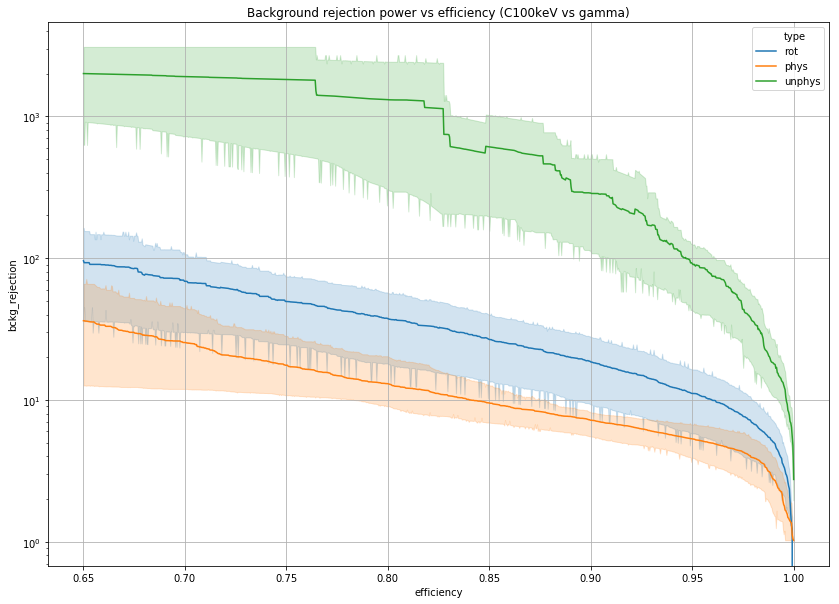




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




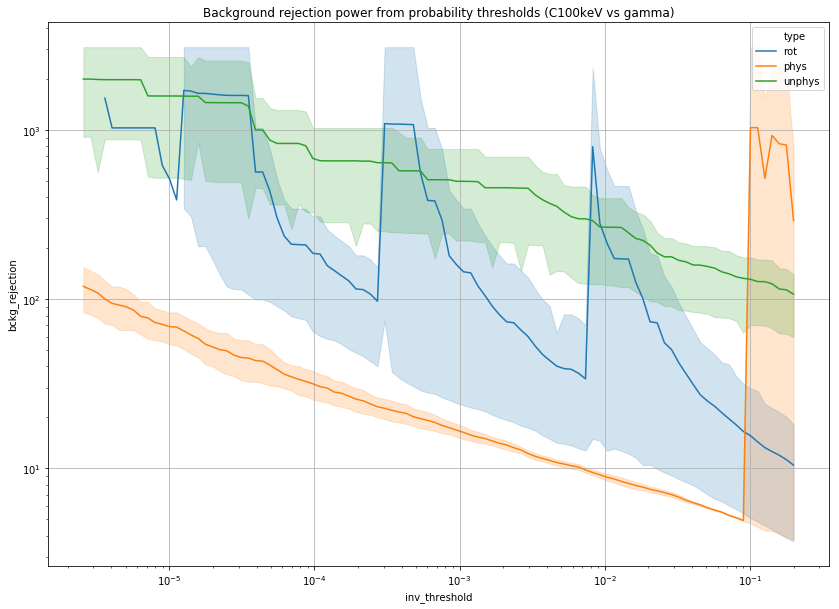

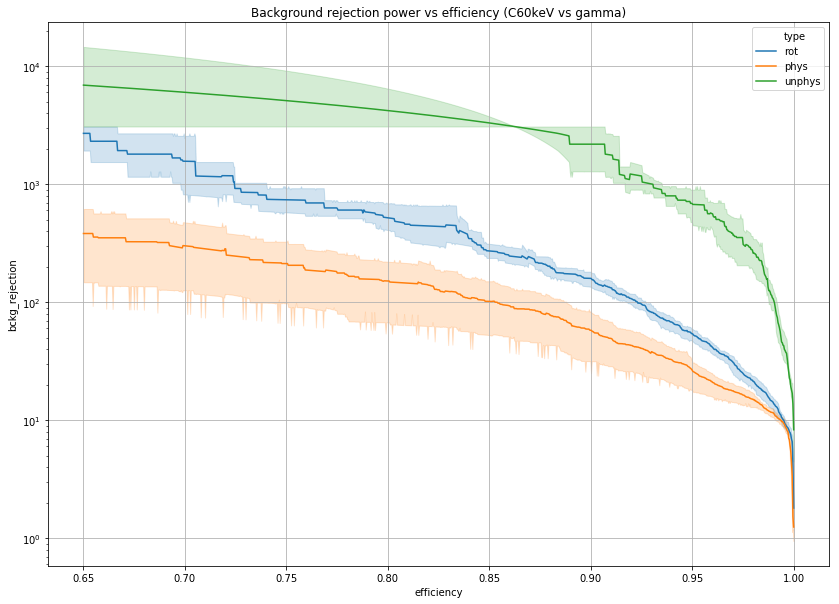




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




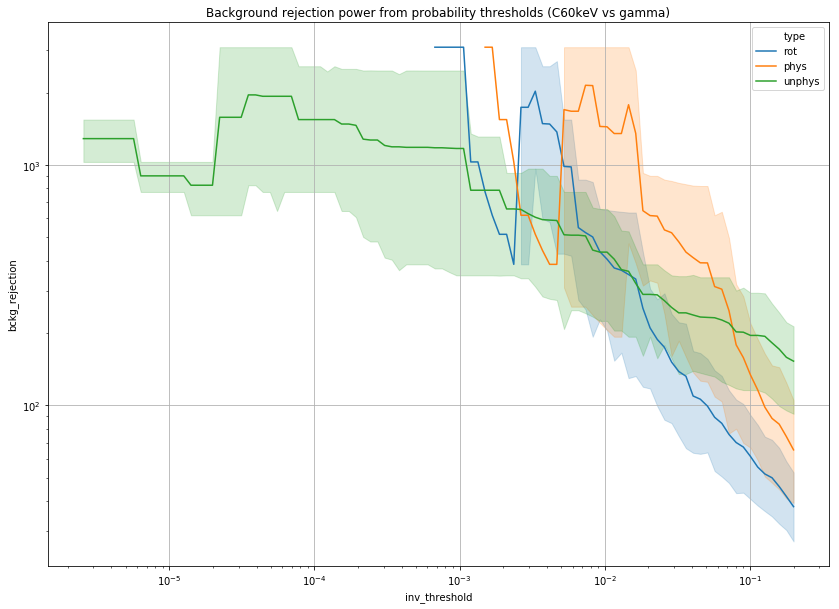

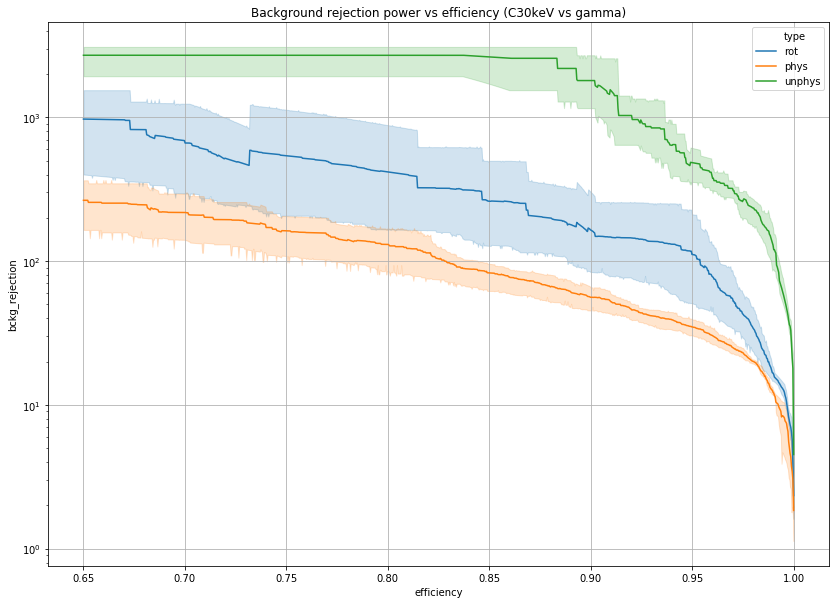




If we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1




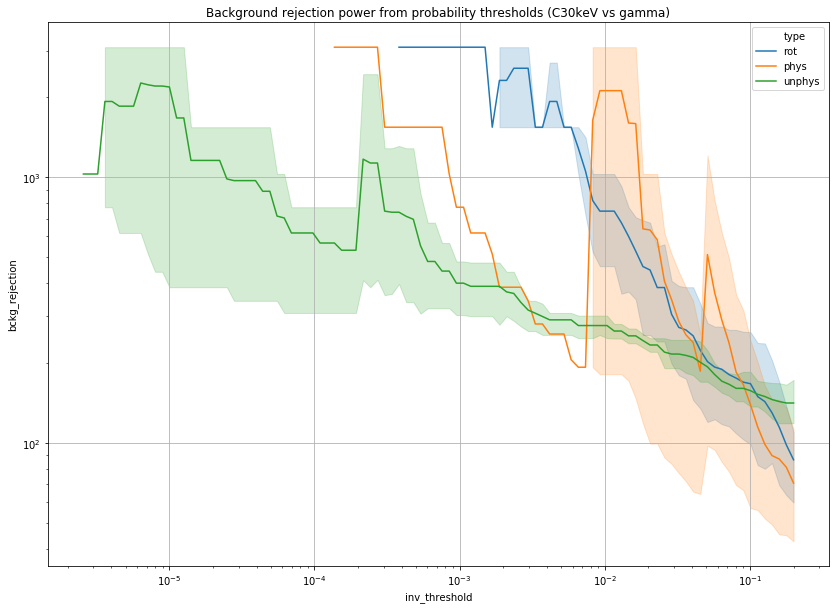

In [54]:
for n in class_names:
    # n is a class (==model)
    #if not any([n in s for s in load_s]): continue
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='efficiency',y='bckg_rejection',hue='type', data=pr_curves[pr_curves['class']==n])
    plt.grid()
    plt.yscale('log')
    #plt.xscale('logit')
    plt.title('Background rejection power vs efficiency ('+n+' vs gamma)')
    plt.show()   

    print('\n\n\nIf we call inverse_threshold = 1-threshold to explore the region of probability threshold close to 1\n\n')
    
    plt.figure(figsize=(14,10))
    sns.lineplot(x='inv_threshold',y='bckg_rejection',hue='type', data=thr_curves[thr_curves['class']==n])
    plt.grid()
    plt.yscale('log')
    plt.xscale('log')
    plt.title('Background rejection power from probability thresholds ('+n+' vs gamma)')
    plt.show()
    
    print('\n\n')

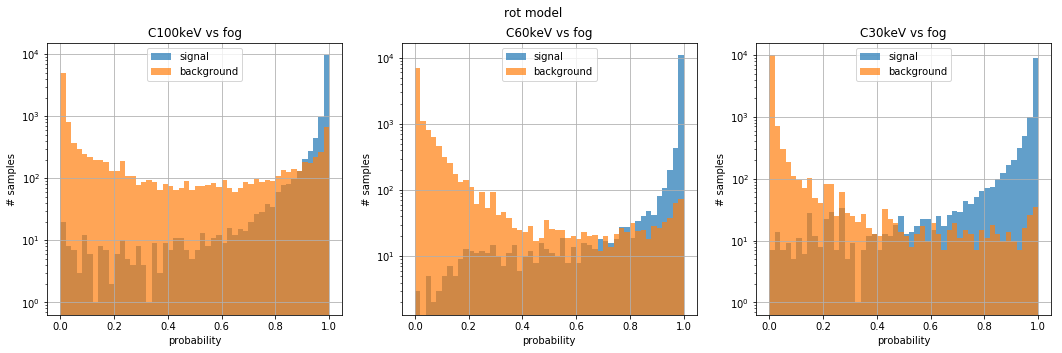

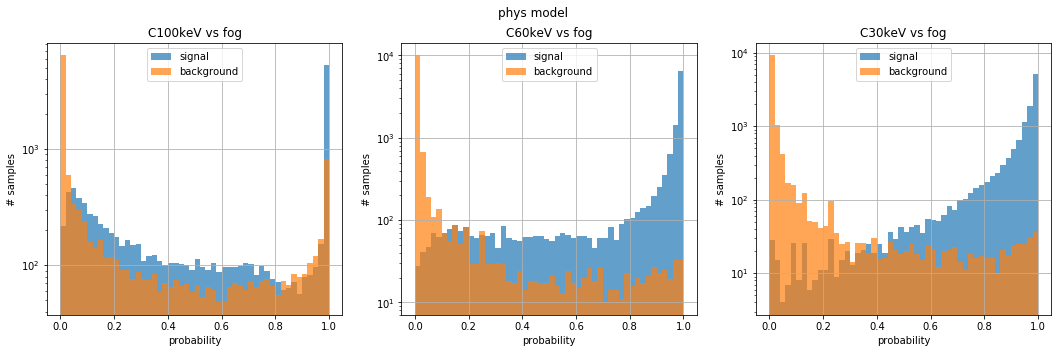

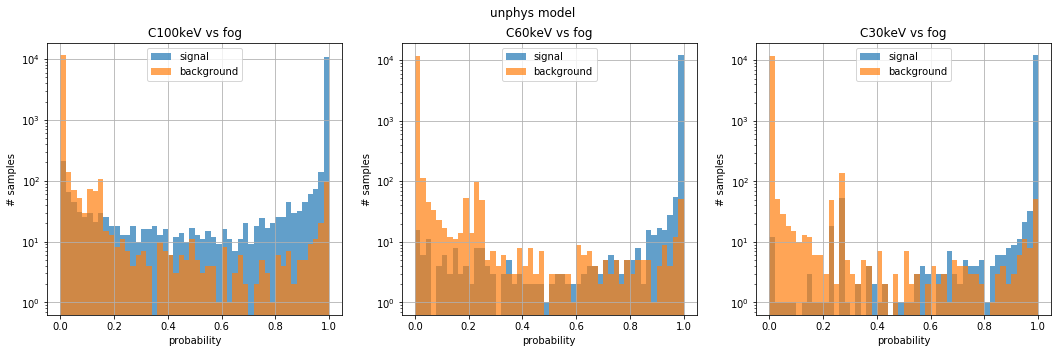

In [20]:
for tr in train_types:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, k in enumerate(class_names):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(k+' vs fog')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(tr+' model')
    plt.show()

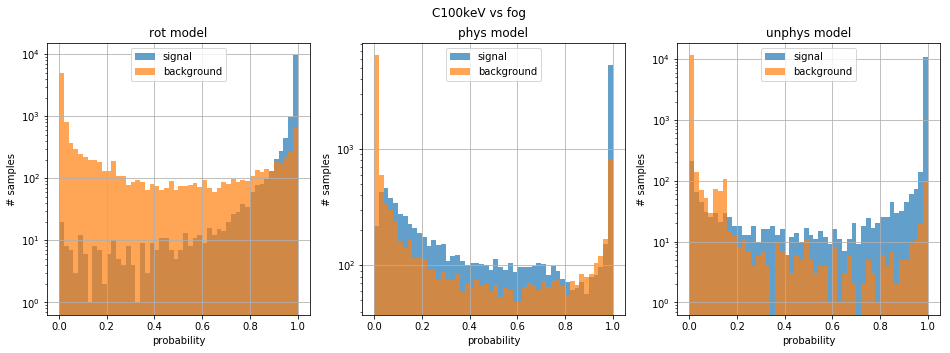

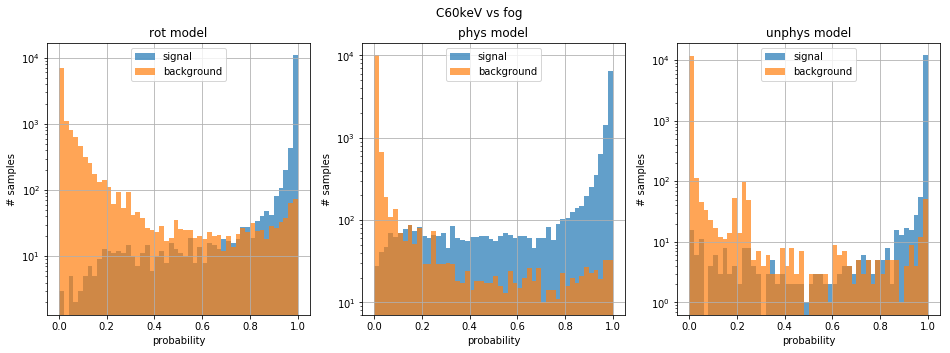

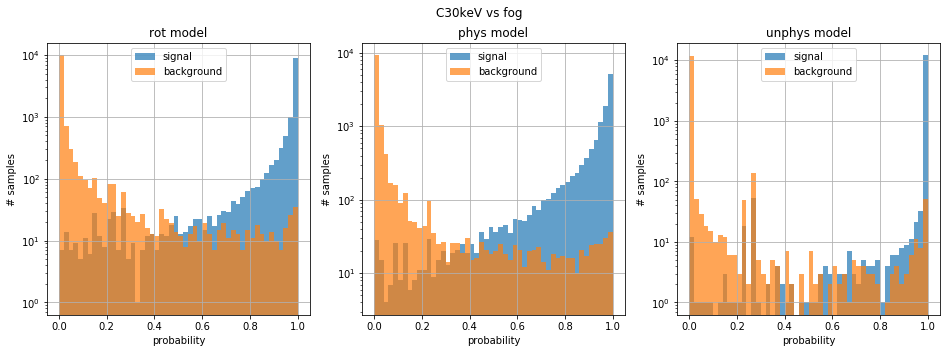

In [21]:
for k in class_names:
    pred_mean, pos, neg = {},{},{}
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    for i, tr in enumerate(train_types):
        n=k
        #if k!='C100keV': continue
        pos[k+'_'+n+'_'+tr], neg[k+'_'+n+'_'+tr] = np.zeros((0,2)), np.zeros((0,2))
        for s in [m for m in load_s if n in m]:
            pos[k+'_'+s+'_'+tr], neg[k+'_'+s+'_'+tr] = pos_neg(preds[k+'_'+s+'_'+tr][:,1], preds[k+'_'+s+'_'+tr][:,0])
            pos[k+'_'+n+'_'+tr] = np.vstack((pos[k+'_'+n+'_'+tr],pos[k+'_'+s+'_'+tr]))
            neg[k+'_'+n+'_'+tr] = np.vstack((neg[k+'_'+n+'_'+tr],neg[k+'_'+s+'_'+tr]))
        axes[i].hist(pos[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='signal', range=(0,1))
        axes[i].hist(neg[k+'_'+n+'_'+tr][:,0], bins=50, alpha=0.7, label='background', range=(0,1))
        axes[i].grid()
        axes[i].set_title(tr+' model')
        axes[i].set_yscale('log')
        axes[i].set_ylabel('# samples')
        axes[i].set_xlabel('probability')
        axes[i].legend(loc=9)
    plt.suptitle(k+' vs fog')
    plt.show()